In [1]:
import warnings
warnings.filterwarnings("ignore")
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import leidenalg
import scipy.sparse as sp
from scipy import sparse
import math
import gseapy as gp

In [2]:
wt = sc.read("../scripts/wt.h5ad")

Tumour-like up genes: 4027
Kept 1633 genes after pct/logFC/Δpct filters.
Top 10 for literature review:


,names,logfoldchanges,pvals_adj,pct_T,pct_W,delta_pct
21,Hexb,6.335,0.0,54.950,2.201,52.749
93,Scimp,5.177,0.0,45.340,2.409,42.931
17,Tgfbr1,3.878,0.0,63.399,10.947,52.452
25,Mtdh,3.890,0.0,58.304,8.082,50.222
1,Fam49b,3.839,0.0,85.231,19.256,65.974
89,Otulinl,4.210,0.0,47.791,5.028,42.764
40,Anp32b,3.850,0.0,54.144,6.963,47.181
172,Rgs10,5.980,0.0,37.794,1.081,36.713
15,Canx,3.404,0.0,67.140,14.058,53.082
5,Stat1,3.406,0.0,77.362,25.289,52.073


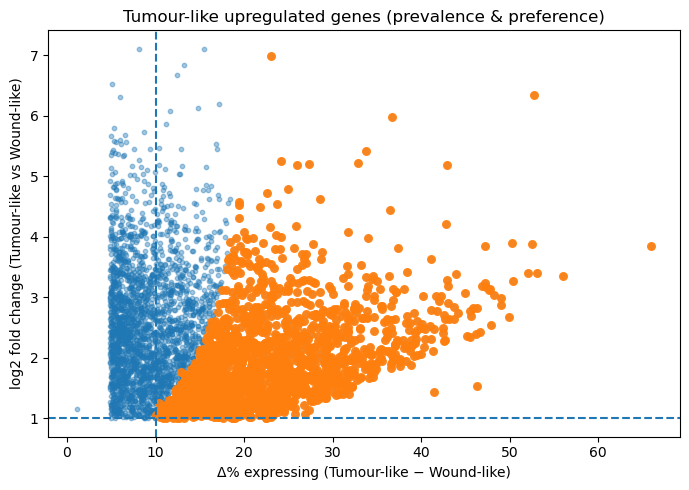

In [4]:
# -----------------------------
# 0) Load your DE table
# -----------------------------
de = pd.read_csv("filterrred_de.csv")  # your FDR<0.001 & |logFC|>1 file
de_tumour_up = de[(de["group"] == "Tumour-like") & (de["logfoldchanges"] > 0)].copy()

print("Tumour-like up genes:", len(de_tumour_up))

# -----------------------------
# 1) Helper: % expressing in a group
#     - Uses sc.get.obs_df to avoid sparse pitfalls
# -----------------------------
def pct_expr(adata, genes, groupby, group, layer=None, threshold=0.0):
    ad = adata[adata.obs[groupby] == group]
    keep = [g for g in genes if g in ad.var_names]
    if not keep:
        return pd.DataFrame(columns=["gene", "pct"])
    df = sc.get.obs_df(ad, keys=keep, layer=layer)  # dense (cells x genes)
    pct = (df.gt(threshold)).mean(axis=0) * 100
    return pct.rename_axis("gene").reset_index(name="pct")

# -----------------------------
# 2) Compute % expressing in each subtype
#    (adjust threshold as you like; 0.0–0.1 is typical for log1p)
# -----------------------------
genes = de_tumour_up["names"].tolist()
pct_T = pct_expr(wt, genes, groupby="neutro_type", group="Tumour-like", layer="log1p", threshold=0.0)
pct_W = pct_expr(wt, genes, groupby="neutro_type", group="Wound-like",  layer="log1p", threshold=0.0)

# Merge into DE table
out = (de_tumour_up
       .merge(pct_T.rename(columns={"pct":"pct_T"}), left_on="names", right_on="gene", how="left")
       .merge(pct_W.rename(columns={"pct":"pct_W"}), left_on="names", right_on="gene", how="left")
      )
out["delta_pct"] = out["pct_T"].fillna(0) - out["pct_W"].fillna(0)

# -----------------------------
# 3) Practical filters (EDITABLE)
# -----------------------------
PCT_MIN_T = 20.0   # "widely expressed" in tumour-like (common standard)
DELTA_MIN  = 10.0  # preferential vs wound-like
LOGFC_MIN  = 1.0   # you already used this in filterrred_de

filtered = out[
    (out["pct_T"] >= PCT_MIN_T) &
    (out["delta_pct"] >= DELTA_MIN) &
    (out["logfoldchanges"] >= LOGFC_MIN)
].copy()

# -----------------------------
# 4) Ranking for a reading shortlist
#    Combine effect size and prevalence
# -----------------------------
# Rank by logFC (desc) and delta_pct (desc), then combine (tunable weights)
filtered["r_logFC"]   = filtered["logfoldchanges"].rank(ascending=False, method="dense")
filtered["r_deltaPct"] = filtered["delta_pct"].rank(ascending=False, method="dense")
filtered["priority_score"] = 0.6*filtered["r_logFC"] + 0.4*filtered["r_deltaPct"]

shortlist = filtered.sort_values(["priority_score","pvals_adj"], ascending=[True, True])

# Save tables
out.to_csv("tumourlike_DE_with_pcts.csv", index=False)
filtered.to_csv("tumourlike_prior_filtered.csv", index=False)
shortlist.to_csv("tumourlike_shortlist_for_literature.csv", index=False)

print(f"Kept {len(filtered)} genes after pct/logFC/Δpct filters.")
print("Top 10 for literature review:")
display(shortlist[["names","logfoldchanges","pvals_adj","pct_T","pct_W","delta_pct"]].head(20).round(3))

# -----------------------------
# 5) Quick visual (optional)
# -----------------------------
plt.figure(figsize=(7,5))
plt.scatter(out["delta_pct"], out["logfoldchanges"], s=10, alpha=0.4)              # all tumour-up
plt.scatter(filtered["delta_pct"], filtered["logfoldchanges"], s=30, alpha=0.9)    # kept ones
plt.axvline(DELTA_MIN, linestyle="--")
plt.axhline(LOGFC_MIN, linestyle="--")
plt.xlabel("Δ% expressing (Tumour-like − Wound-like)")
plt.ylabel("log2 fold change (Tumour-like vs Wound-like)")
plt.title("Tumour-like upregulated genes (prevalence & preference)")
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd

de = pd.read_csv("filterrred_de.csv")
# Keep only Tumour-like upregulated genes
de_tumour_up = de[(de["group"] == "Tumour-like") & (de["logfoldchanges"] > 0)].copy()
print("Tumour-like upregulated genes:", len(de_tumour_up))


Tumour-like upregulated genes: 4027


In [11]:
import scanpy as sc

def pct_expr_with_obs_df(adata, genes, groupby="neutro_type", group="Tumour-like", layer=None, threshold=0.0):
    ad = adata[adata.obs[groupby] == group]
    genes = [g for g in genes if g in ad.var_names]
    if not genes:
        return pd.DataFrame(columns=["gene","pct_expr_cells"])
    df = sc.get.obs_df(ad, keys=genes, layer=layer)   # dense small matrix (cells x genes)
    pct = (df.gt(threshold)).mean(axis=0) * 100
    return pct.rename_axis("gene").reset_index(name="pct_expr_cells")



In [6]:
wt = sc.read("../scripts/wt.h5ad")

In [8]:
print("Layers:", list(wt.layers.keys()))

Layers: ['X_detected', 'X_preNorm', 'X_scaled_normalised', 'counts', 'log1p']


In [12]:
pct_df = pct_expr_with_obs_df(wt, de_tumour_up["names"], group="Tumour-like", groupby="neutro_type", layer="log1p", threshold=0.0)


In [13]:
pct_df


,gene,pct_expr_cells
0,Txnip,96.517252
1,Fam49b,85.230571
2,H2-K1,97.065463
3,Ctss,83.714931
4,B2m,99.516285
...,...,...
4022,Zc3h6,6.578523
4023,Dvl1,7.255724
4024,Unc119,8.771364
4025,Aasdhppt,5.449855


In [14]:
merged = de_tumour_up.merge(pct_df, left_on="names", right_on="gene", how="left")
tumourlike_highExpr = (
    merged[merged["pct_expr_cells"] >= 20]
    .sort_values("logfoldchanges", ascending=False)
)
tumourlike_highExpr.to_csv("tumourlike_highExpr_filtered.csv", index=False)
tumourlike_highExpr[["names","pct_expr_cells","logfoldchanges","pvals_adj"]].head(20)


,names,pct_expr_cells,logfoldchanges,pvals_adj
736,Ltc4s,23.282812,6.979111,5.646876e-68
21,Hexb,54.950016,6.334675,0.000000e+00
172,Rgs10,37.794260,5.979932,2.392083e-173
235,Ptgs1,35.311190,5.420949,1.362676e-147
644,Col15a1,25.249919,5.248109,9.704088e-76
260,Ffar2,34.472751,5.215961,4.849522e-139
467,Gm19951,28.668172,5.205803,2.960446e-96
93,Scimp,45.340213,5.177260,3.656292e-239
534,AU020206,27.152531,5.177101,3.931779e-87
611,Banf1,26.185102,4.796240,4.305128e-80


In [16]:
tumourlike_highExpr

,group,names,scores,logfoldchanges,pvals,pvals_adj,gene,pct_expr_cells
736,Tumour-like,Ltc4s,17.608265,6.979111,2.128721e-69,5.646876e-68,Ltc4s,23.282812
21,Tumour-like,Hexb,40.980736,6.334675,0.000000e+00,0.000000e+00,Hexb,54.950016
172,Tumour-like,Rgs10,28.225965,5.979932,2.808162e-175,2.392083e-173,Rgs10,37.794260
235,Tumour-like,Ptgs1,26.034567,5.420949,2.012045e-149,1.362676e-147,Ptgs1,35.311190
644,Tumour-like,Col15a1,18.599016,5.248109,3.272551e-77,9.704088e-76,Col15a1,25.249919
...,...,...,...,...,...,...,...,...
1825,Tumour-like,Asap1,10.088665,1.003279,6.200724e-24,6.735828e-23,Asap1,29.990326
956,Tumour-like,Ppp2r5c,15.303962,1.003178,7.194110e-53,1.477000e-51,Ppp2r5c,49.629152
2476,Tumour-like,Cd101,7.634012,1.002406,2.275594e-14,1.810771e-13,Cd101,22.089649
2360,Tumour-like,Topors,8.039895,1.002230,8.991519e-16,7.509999e-15,Topors,21.186714
